# Training y in bankdata
Binary Classification model by [DeepTables](https://github.com/DataCanvasIO/DeepTables), Generated on 2020-12-23 11:18:54

In [1]:
# -*- encoding: utf-8 -*-
import pandas as pd
import sklearn
import math
import shap
import requests
import pickle
import numpy as np
import matplotlib.pyplot as plt
from os import path as P
from sklearn.model_selection import train_test_split
from sklearn import metrics

from cooka.common import dataset_util
from cooka.common import util
from deeptables.models.hyper_dt import HyperDT, DnnModule, DTModuleSpace, DTFit, DTEstimator
from deeptables.utils import consts as DT_consts
from deeptables.utils.shap import DeepTablesExplainer

from hypernets.core.callbacks import *
from hypernets.core.ops import HyperInput, ModuleChoice
from hypernets.core.search_space import *
from hypernets.core.searcher import OptimizeDirection
from hypernets.searchers.mcts_searcher import MCTSSearcher

from hypergbm.estimators import LightGBMEstimator, XGBoostEstimator, CatBoostEstimator
from hypergbm.hyper_gbm import HyperGBM
from hypergbm.pipeline import DataFrameMapper
from hypergbm.sklearn.sklearn_ops import numeric_pipeline_complex, categorical_pipeline_simple
from hypernets.searchers.random_searcher import RandomSearcher
from hypergbm.search_space import search_space_general
from hypernets.experiment.general import GeneralExperiment
from tabular_toolbox.column_selector import column_object

shap.initjs()

## [1]. train config

In [2]:

train_file_path = "/home/wuhf/cooka/dataset/bankdata/data.csv"
test_file_path = None
server_portal = "http://localhost:8240"
max_trails = 1
task_type = "binary_classification"
dataset_name = "bankdata"
dataset_has_header = True

dataset_default_headers = None
label_col = "y"
pos_label = "yes"
train_mode = "minimal"
framework = "DeepTables"
partition_strategy = "train_validation_holdout"
holdout_percentage = 10
n_folds = None
train_percentage = 80
validation_percentage = 10
datetime_series_col = None
train_job_name = "train_job_bankdata_DeepTables_20201223111853903759"
model_name = "bankdata_2"
model_feature_list = [{"name": "duration", "type": "continuous", "data_type": "int64"}, {"name": "contact", "type": "categorical", "data_type": "object"}, {"name": "housing", "type": "categorical", "data_type": "object"}, {"name": "pdays", "type": "continuous", "data_type": "int64"}, {"name": "previous", "type": "continuous", "data_type": "int64"}, {"name": "poutcome", "type": "categorical", "data_type": "object"}, {"name": "campaign", "type": "continuous", "data_type": "int64"}, {"name": "loan", "type": "categorical", "data_type": "object"}, {"name": "education", "type": "categorical", "data_type": "object"}, {"name": "balance", "type": "continuous", "data_type": "int64"}, {"name": "marital", "type": "categorical", "data_type": "object"}, {"name": "job", "type": "categorical", "data_type": "object"}, {"name": "day", "type": "continuous", "data_type": "int64"}, {"name": "age", "type": "continuous", "data_type": "int64"}, {"name": "month", "type": "categorical", "data_type": "object"}, {"name": "default", "type": "categorical", "data_type": "object"}]
data_root = "/home/wuhf/cooka"


## [2]. data partition

In [3]:
df = pd.read_csv(train_file_path)


X_train, X_test = train_test_split(df, test_size=0.1,  random_state=42, shuffle=True)

y_train = X_train.pop(label_col)
y_test = X_test.pop(label_col)
X_train = dataset_util.cast_df(X_train, model_feature_list, remove_unnecessary_cols=True)
X_test = dataset_util.cast_df(X_test, model_feature_list, remove_unnecessary_cols=True)
classes = list(set(y_train).union(set(y_test)))

## [3]. search best params

In [4]:
reward_metric =  "AUC"
optimize_direction = OptimizeDirection.Maximize
print(f"Optimize direction: {optimize_direction}, reward metric: reward_metric")



# minimal space
def search_space():
    space = HyperSpace()
    with space.as_default():
        dt_module = DTModuleSpace(
            nets=Choice([['linear']]),
            auto_categorize=Choice([False]),
            cat_remain_numeric=Choice([False]),
            auto_discrete=Choice([False]),
            # apply_gbm_features=Bool(),
            # gbm_feature_type=Choice([DT_consts.GBM_FEATURE_TYPE_DENSE, DT_consts.GBM_FEATURE_TYPE_EMB]),
            embeddings_output_dim=Choice([4]),
            embedding_dropout=Choice([0]),
            stacking_op=Choice([DT_consts.STACKING_OP_ADD]),
            output_use_bias=Choice([False]),
            apply_class_weight=Choice([False]),
            earlystopping_patience=Choice([1]))
        dnn = DnnModule(dnn_units=Choice([10]),
                        reduce_factor=Choice([1, 0.8]),
                        dnn_dropout=Choice([0]),
                        use_bn=Bool(),
                        dnn_layers=2,
                        activation='relu')(dt_module)
        fit = DTFit(batch_size=Choice([64]), epochs=2)(dt_module)
    return space


rs = MCTSSearcher(search_space, max_node_space=10, optimize_direction=optimize_direction)

hk = HyperDT(rs,
             callbacks=[SummaryCallback(), FileLoggingCallback(rs), EarlyStoppingCallback(max_no_improvement_trails=5, mode=optimize_direction.value)],
             reward_metric=reward_metric,
             dnn_params={
                 'dnn_units': ((256, 0, False), (256, 0, False)),
                 'dnn_activation': 'relu'})
hk.search(X_train, y_train, X_test, y_test, max_trails=max_trails)
best_trial = hk.get_best_trail()
estimator = hk.final_train(best_trial.space_sample, X_train, y_train)


Optimize direction: OptimizeDirection.Maximize, reward metric: reward_metric
11:24:40 I hypernets.m.hyper_model.py 186 - 2 class detected, {'yes', 'no'}, so inferred as a [binary classification] task
11:24:40 I hypernets.c.meta_learner.py 22 - Initialize Meta Learner: dataset_id:de8e3a4f080ffc9c88ae5a68f8e93c4c
11:24:40 I hypernets.c.callbacks.py 165 - 
Trail No:1
--------------------------------------------------------------
(0) Module_DnnModule_1.hidden_units:                      800
(1) Module_DnnModule_1.reduce_factor:                       1
(2) Module_DnnModule_1.use_bn:                           True
--------------------------------------------------------------
trail 1 begin
---------no summary-------------
current does not exsit.
2 class detected, {'yes', 'no'}, so inferred as a [binary classification] task
Preparing features taken 0.018545150756835938s
Imputation taken 0.07982707023620605s
Categorical encoding taken 0.12746691703796387s
Injected a callback [EarlyStopping]. m

## [4]. evaluate

In [5]:

y_pred = estimator.predict(X_test)

y_score = estimator.predict_proba(X_test)
y_pos_score = y_score[:, 1]



## 5. Plot confusion matrix

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


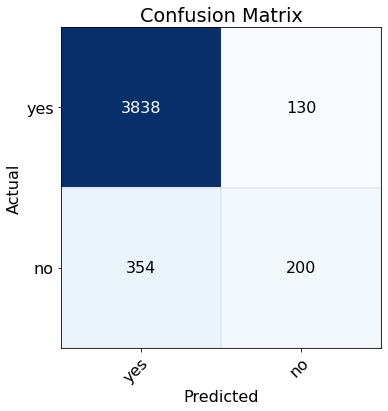

In [6]:


confusion_matrix_data = metrics.confusion_matrix(y_test, y_pred)

plt.rc('font',family='Times New Roman',size='16')
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(confusion_matrix_data, interpolation='nearest', cmap=plt.cm.Blues)
# ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(confusion_matrix_data.shape[1]),
       yticks=np.arange(confusion_matrix_data.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title='Confusion Matrix',
       ylabel='Actual',
       xlabel='Predicted')

ax.set_xticks(np.arange(confusion_matrix_data.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(confusion_matrix_data.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.2)
ax.tick_params(which="minor", bottom=False, left=False)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")


thresh = confusion_matrix_data.max() / 2.
for i in range(confusion_matrix_data.shape[0]):
    for j in range(confusion_matrix_data.shape[1]):
        if int(confusion_matrix_data[i, j]*100 + 0.5) > 0:
            ax.text(j, i, confusion_matrix_data[i, j], ha="center", va="center", color="white" if confusion_matrix_data[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

## 6. Plot roc curve

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


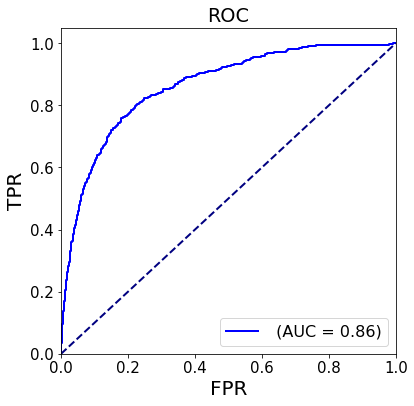

In [10]:

fpr, tpr, threshold = metrics.roc_curve(y_test, y_score[:, 1], pos_label=pos_label)
roc_auc = metrics.auc(fpr,tpr)
plt.figure(figsize=(6,6), facecolor=(1, 1, 1))
lw = 2
# darkorange
plt.plot(fpr, tpr, color='blue', lw=lw, label=' (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('FPR', fontsize=20)
plt.ylabel('TPR', fontsize=20)
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [11]:
dt_explainer = DeepTablesExplainer(estimator, X_test, num_samples=100)
shap_values = dt_explainer.get_shap_values(X_test[:1], nsamples='auto')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


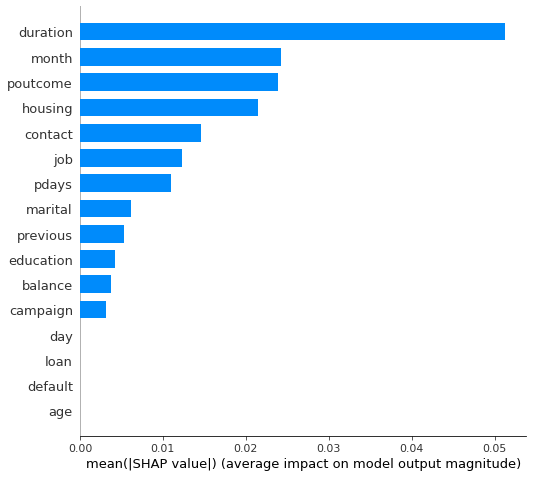

In [12]:
shap.summary_plot(shap_values,X_test, plot_type="bar")

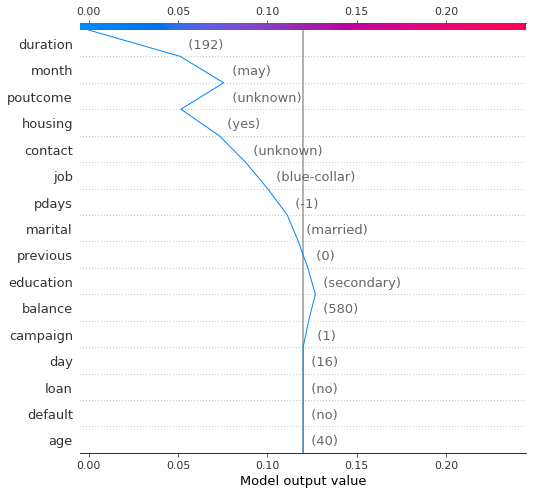

In [13]:
shap.decision_plot(dt_explainer.explainer.expected_value, shap_values[0], X_test.iloc[0])